## 443 Homework 2 - B2B Pricing
### Shaolong "Fred" Xue

### **Set-up**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar

In [3]:
link = "https://raw.githubusercontent.com/ormarketing/b2b/master/data.csv"
data = pd.read_csv(link)

In [4]:
# Rewrite stage variable
data.loc[data['Stage'].str.contains('Won'), 'Stage'] = 'Won'
data.loc[data['Stage'].str.contains('Lost'), 'Stage'] = 'Lost'

In [5]:
# One hot encode the type variable
one_hot_encoded = pd.get_dummies(data['Type'], prefix='Type')
data = pd.concat([data, one_hot_encoded], axis=1)

In [6]:
# Rename columns
data.rename(columns={'Type_Direct - Cloud Product': 'Direct Cloud', 'Type_Direct - OnPremise Product': 'Direct OnPrem', 
                     'Type_Partner - Cloud Product': 'Partner Cloud', 'Type_Partner - OnPremise Product': 'Partner OnPrem'}, inplace=True)

In [7]:
data['Amount'] = pd.to_numeric(data[' Amount '], errors='coerce')
data['Net Amount'] = pd.to_numeric(data[' Net Amount '], errors='coerce')
data['Discount'] = data['Amount'] - data['Net Amount']

In [8]:
data = data.drop([' ACV ',' Discount Amount ',' Amount ', ' Net Amount ', 'Type', 'Billing Plan'],axis=1)

In [9]:
na_counts = data.isna().sum()

In [10]:
print(na_counts)

ID                 0
Close Date         0
Created Date       0
New Logo           0
Stage              0
Direct Cloud       0
Direct OnPrem      0
Partner Cloud      0
Partner OnPrem     0
Amount            49
Net Amount        49
Discount          50
dtype: int64


In [11]:
# Create binary outcome variable
data['y'] = np.where(data['Stage'] == 'Won', 1.0, 0.0)

# Convert Close Date to datetime format
data['Close Date'] = pd.to_datetime(data['Close Date'])

# Create quarter variable to capture end of the quarter effect
data['Quarter'] = data['Close Date'].dt.quarter
data['Quarter'] = data['Quarter'].astype(str)
# One hot encode the Quarter variable
one_hot_encoded2 = pd.get_dummies(data['Quarter'], prefix='Quarter')
data = pd.concat([data, one_hot_encoded2], axis=1)
# Rename columns
data.rename(columns={'Quarter_1': 'Q1', 'Quarter_2': 'Q2', 
                     'Quarter_3': 'Q3', 'Quarter_4': 'Q4'}, inplace=True)
data = data.drop(['Quarter'], axis=1)

In [12]:
# Create Month variable
data['Month'] = data['Close Date'].dt.month
one_hot_encoded3 = pd.get_dummies(data['Month'], prefix='Month')
data = pd.concat([data, one_hot_encoded3], axis=1)

In [13]:
data.head(5)

,ID,Close Date,Created Date,New Logo,Stage,Direct Cloud,Direct OnPrem,Partner Cloud,Partner OnPrem,Amount,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,1,2017-05-26,5/4/17,1,Lost,1,0,0,0,225000.0,...,0,0,1,0,0,0,0,0,0,0
1,2,2016-12-29,11/29/16,1,Won,0,0,0,1,147000.0,...,0,0,0,0,0,0,0,0,0,1
2,3,2016-12-29,12/9/16,1,Won,0,0,1,0,96000.0,...,0,0,0,0,0,0,0,0,0,1
3,4,2016-09-09,4/20/16,1,Won,1,0,0,0,128000.0,...,0,0,0,0,0,0,1,0,0,0
4,5,2016-09-22,9/1/16,1,Won,0,0,0,1,66000.0,...,0,0,0,0,0,0,1,0,0,0


In [14]:
data.dtypes

ID                         int64
Close Date        datetime64[ns]
Created Date              object
New Logo                   int64
Stage                     object
Direct Cloud               uint8
Direct OnPrem              uint8
Partner Cloud              uint8
Partner OnPrem             uint8
Amount                   float64
Net Amount               float64
Discount                 float64
y                        float64
Q1                         uint8
Q2                         uint8
Q3                         uint8
Q4                         uint8
Month                      int64
Month_1                    uint8
Month_2                    uint8
Month_3                    uint8
Month_4                    uint8
Month_5                    uint8
Month_6                    uint8
Month_7                    uint8
Month_8                    uint8
Month_9                    uint8
Month_10                   uint8
Month_11                   uint8
Month_12                   uint8
dtype: obj

### **Split the data**

In [43]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

We used a 8-2 ratio to split the data into training and test sets. 

### **End-of-the-Quarter Effect**

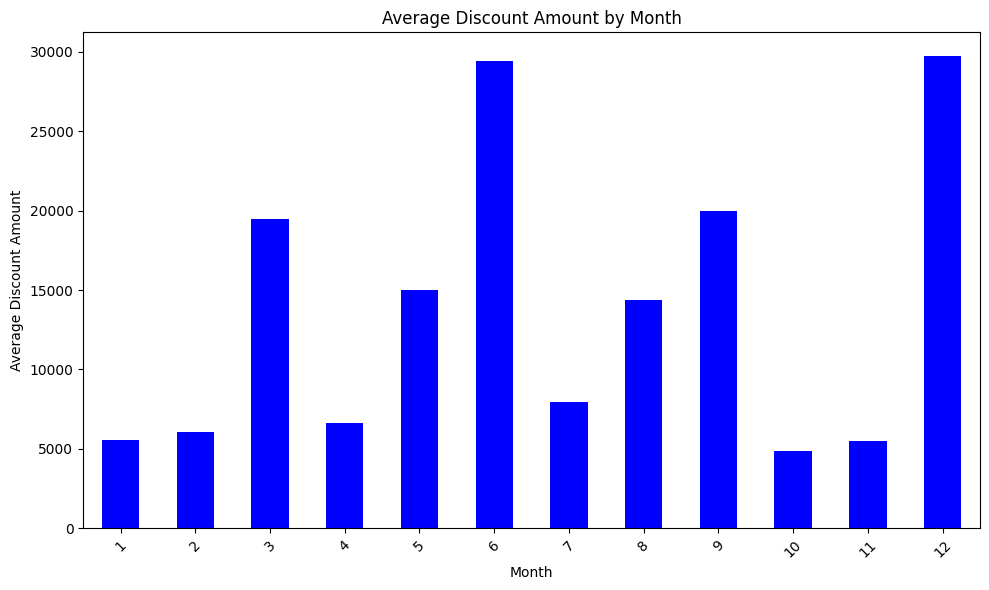

In [16]:
# Calculate the average discount amount in each month
avg_discount = data.groupby('Month')['Discount'].mean()

# Plot the average discount amount by month
plt.figure(figsize=(10, 6))
avg_discount.plot(kind='bar', color='blue')
plt.xlabel('Month')
plt.ylabel('Average Discount Amount')
plt.title('Average Discount Amount by Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the plot, end of the quarter months (March, June, September, and December) all have visibly higher average discount amount than the rest of the months. 

Visually, the end-of-the-quarter effect seems true. 

In [17]:
y_train = train_data['Discount']
x_train = train_data[['Month_2', 'Month_3','Month_4', 'Month_5',
                      'Month_6', 'Month_7','Month_8', 'Month_9', 
                      'Month_10', 'Month_11','Month_12']]
x_train = sm.add_constant(x_train)
ols = sm.OLS(y_train, x_train, missing='drop')
results = ols.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Discount   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.339
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           0.000151
Time:                        15:31:24   Log-Likelihood:                -14369.
No. Observations:                1165   AIC:                         2.876e+04
Df Residuals:                    1153   BIC:                         2.882e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6345.7980   5553.875      1.143      0.2

From the OLS regression, it shows June and December are statistically significant under 0.05 alpha, and these months bring a much higher discount on average than January, comparing to other months. 

Therefore, we can safely conclude the end-of-the-quarter effect is true.

### **Modeling**

In [44]:
y_train = train_data['y']
x_train = train_data[['Discount', 'Amount', 'New Logo', 'Q1', 'Q2', 'Q3']]
x_train = sm.add_constant(x_train)
model = sm.Logit(y_train, x_train, missing='drop')
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.413617
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1165
Model:                          Logit   Df Residuals:                     1158
Method:                           MLE   Df Model:                            6
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.3732
Time:                        15:40:48   Log-Likelihood:                -481.86
converged:                       True   LL-Null:                       -768.71
Covariance Type:            nonrobust   LLR p-value:                1.096e-120
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6254      0.169     -3.703      0.000      -0.956      -0.294
Discount    3.455e-05   5.72e

In [45]:
y_train = train_data['y']
# Removed Partner OnPrem to avoid perfert multicolinearity
x_train = train_data[['Discount', 'Amount', 'New Logo', 
                      'Q1', 'Q2', 'Q3', 
                      'Direct Cloud', 'Direct OnPrem', 'Partner Cloud']]
model2 = sm.Logit(y_train, x_train, missing='drop')
results = model2.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.401327
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1165
Model:                          Logit   Df Residuals:                     1156
Method:                           MLE   Df Model:                            8
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.3918
Time:                        15:40:48   Log-Likelihood:                -467.55
converged:                       True   LL-Null:                       -768.71
Covariance Type:            nonrobust   LLR p-value:                7.357e-125
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Discount       3.359e-05   5.77e-06      5.822      0.000    2.23e-05    4.49e-05
Amount        -3.649

In [46]:
y_train = train_data['y']
# Removed Partner OnPrem to avoid perfert multicolinearity
x_train = train_data[['Discount', 'Amount', 'New Logo', 
                      'Direct Cloud', 'Direct OnPrem', 'Partner Cloud']]
model3 = sm.Logit(y_train, x_train, missing='drop')
results = model3.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.511236
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1165
Model:                          Logit   Df Residuals:                     1159
Method:                           MLE   Df Model:                            5
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.2252
Time:                        15:40:48   Log-Likelihood:                -595.59
converged:                       True   LL-Null:                       -768.71
Covariance Type:            nonrobust   LLR p-value:                 1.124e-72
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Discount       6.004e-05   6.45e-06      9.314      0.000    4.74e-05    7.27e-05
Amount        -1.439

In [51]:
y_train = train_data['y']
# Removed Partner OnPrem to avoid perfert multicolinearity
x_train = train_data[['Discount', 'Amount', 'New Logo', 
                      'Direct Cloud', 'Direct OnPrem', 'Partner Cloud',
                      'Month_2', 'Month_3','Month_4', 'Month_5',
                      'Month_6', 'Month_7','Month_8', 'Month_9', 
                      'Month_10', 'Month_11','Month_12']]
model4 = sm.Logit(y_train, x_train, missing='drop')
results = model4.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.378157
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1165
Model:                          Logit   Df Residuals:                     1148
Method:                           MLE   Df Model:                           16
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.4269
Time:                        15:42:00   Log-Likelihood:                -440.55
converged:                       True   LL-Null:                       -768.71
Covariance Type:            nonrobust   LLR p-value:                2.517e-129
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Discount       3.536e-05   5.99e-06      5.905      0.000    2.36e-05    4.71e-05
Amount        -7.775

### **Computing Optimal Discount**

In [61]:
# Calculate the optimal discounts
optimal_discounts = []

# Loop to optimize discounts for each individual lead
for _, row in test_data.iterrows():
    UT = np.dot(row[['Amount', 'New Logo', 
                      'Direct Cloud', 'Direct OnPrem', 'Partner Cloud',
                      'Month_2', 'Month_3','Month_4', 'Month_5',
                      'Month_6', 'Month_7','Month_8', 'Month_9', 
                      'Month_10', 'Month_11','Month_12']], results.params[1:17])
    b = results.params[0]
    p = row['Amount']

    def revenueD(d):
        """This is the negative revenue function"""
        return -np.exp(UT + b * np.sqrt(d**2)) / (1 + np.exp(UT + b * np.sqrt(d**2))) * (p - np.sqrt(d**2))

    sol = minimize_scalar(revenueD)
    optimal_discounts.append(sol.x)

# Add the optimal discounts to the hold-out sample
test_data['Optimal Discount'] = optimal_discounts

print(round(np.mean(optimal_discounts), 0), np.round(np.mean(test_data['Discount']), 0))

19386.0 13241.0


In [66]:
test_data.head(5)

,ID,Close Date,Created Date,New Logo,Stage,Direct Cloud,Direct OnPrem,Partner Cloud,Partner OnPrem,Amount,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Optimal Discount
51,52,2017-03-24,9/20/16,1,Won,0,0,1,0,225000.0,...,0,0,0,0,0,0,0,0,0,42499.432450
976,977,2016-11-14,10/10/16,0,Lost,0,0,0,1,50000.0,...,0,0,0,0,0,0,0,1,0,964.885616
184,185,2017-07-06,4/7/17,1,Won,0,0,0,1,157500.0,...,0,0,0,1,0,0,0,0,0,86010.891110
1001,1002,2017-06-16,12/12/16,1,Won,0,0,0,1,750000.0,...,0,0,1,0,0,0,0,0,0,210407.106126
746,747,2016-03-01,10/19/15,0,Lost,0,1,0,0,13780.0,...,0,0,0,0,0,0,0,0,0,0.000000


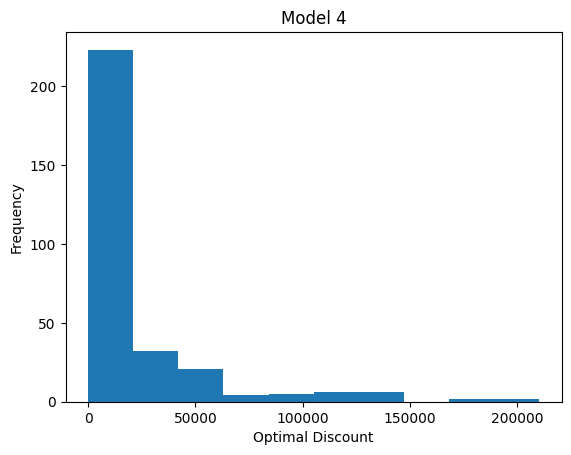

In [67]:
plt.hist(test_data['Optimal Discount'], bins=10)  # Replace 'ColumnName' with the actual column name
plt.xlabel('Optimal Discount')
plt.ylabel('Frequency')
plt.title('Model 4')
plt.show()

### **Calculate Revenue Improvement**

In [ ]:
# revenue, un-optimzed discounts 
xS = test_data[['Discount', 'Amount', 'New Logo', 
                'Direct Cloud', 'Direct OnPrem', 'Partner Cloud',
                'Month_2', 'Month_3','Month_4', 'Month_5',
                'Month_6', 'Month_7','Month_8', 'Month_9', 
                'Month_10', 'Month_11','Month_12']]

ID=0
ID_max=301
rev_unopt=np.empty([ID_max,])

while ID<=ID_max-1:
  j=0
  u=0
  while j<=16:
    u=u+xS.iloc[ID][j]*results.params[j]
    j=j+1
    proba=np.exp(u)/(1+np.exp(u))
    rev_unopt[ID] = proba * (xS['Amount'].values[ID] - xS['Discount'].values[ID])
  ID=ID+1

rev_unopt=np.nan_to_num(rev_unopt);

In [97]:
# revenue, optimzed discounts 
xS2 = test_data[['Optimal Discount', 'Amount', 'New Logo', 
                'Direct Cloud', 'Direct OnPrem', 'Partner Cloud',
                'Month_2', 'Month_3','Month_4', 'Month_5',
                'Month_6', 'Month_7','Month_8', 'Month_9', 
                'Month_10', 'Month_11','Month_12']]

ID=0
ID_max=301
rev_opt=np.empty([ID_max,])

while ID<=ID_max-1:
  j=0
  u=0
  while j<=16:
    u=u+xS2.iloc[ID][j]*results.params[j]
    j=j+1
    proba=np.exp(u)/(1+np.exp(u))
    rev_opt[ID] = proba * (xS2['Amount'].values[ID] - xS2['Optimal Discount'].values[ID])
  ID=ID+1

rev_opt=np.nan_to_num(rev_opt);

In [105]:
test_data['Revenue'] = np.where(test_data['Stage'] == 'Won', test_data['Net Amount'], 0.0)

In [110]:
print('Expected revenue improvement over un-optimized discounts:', round(np.sum(rev_unopt) / np.sum(test_data['Revenue']), 2))
print('Expected revenue improvement over optimized discounts:', round(np.sum(rev_opt) / np.sum(test_data['Revenue']), 2))

Expected revenue improvement over un-optimized discounts: 0.93
Expected revenue improvement over optimized discounts: 1.24


In [113]:
test_data['Optimized Revenue'] = rev_opt
test_data['Optimized Revenue'] = np.where(test_data['Stage'] == 'Won', test_data['Optimized Revenue'], 0.0)

In [119]:
df = test_data[['Month','Discount','Revenue','Optimal Discount', 'Optimized Revenue']]

print(round(df.groupby('Month').mean(), 2))

       Discount   Revenue  Optimal Discount  Optimized Revenue
Month                                                         
1       2923.45   6690.34           7501.48            7798.44
2       8921.76  14219.05          14501.10           12594.38
3      22186.91  40360.88          17207.94           42283.63
4       3486.00   7285.45          14015.55            3919.89
5      17223.55  35297.42          32608.96           21804.88
6      28681.48  49925.71          31328.19           46019.17
7       4076.36   6875.76          24337.03            2051.31
8      16828.12  28258.75          24486.82           19527.16
9      13531.47  32127.35          16584.82           32536.13
10     13247.32  50617.42          22808.08           41117.52
11      8525.00   5692.31           9810.26            5216.45
12     13589.31  35755.85           7740.44           38822.84
